# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date:  2023**

# Notebook 2b. Labelled Model Training

## 2.0 Imports

In [153]:
# Standard Libraries for data manipulation
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import string

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [154]:
df = pd.read_csv('../data/annotation file 3600 done 1142022.csv')

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   link_id    5001 non-null   object
 1   parent_id  5001 non-null   object
 2   User       5001 non-null   object
 3   Text       5001 non-null   object
 4   Intent     5001 non-null   object
 5   Support    5001 non-null   object
dtypes: object(6)
memory usage: 235.4+ KB


In [156]:
df.describe()

,link_id,parent_id,User,Text,Intent,Support
count,5001,5001,5001,5001,5001,5001
unique,1948,3153,4662,4952,6,4
top,t3_ladzdt,t3_ladzdt,AutoModerator,GME,u,y
freq,66,46,14,22,3246,2473


In [157]:
df['link_id'].nunique() == df.shape[0]

False

In [158]:
df.isna().sum()/df.shape[0]

link_id      0.003785
parent_id    0.003785
User         0.003785
Text         0.003785
Intent       0.003785
Support      0.003785
dtype: float64

In [159]:
df[ df['Text'].isna() ]

,link_id,parent_id,User,Text,Intent,Support
5001,NaN,NaN,NaN,NaN,NaN,NaN
5002,NaN,NaN,NaN,NaN,NaN,NaN
5003,NaN,NaN,NaN,NaN,NaN,NaN
5004,NaN,NaN,NaN,NaN,NaN,NaN
5005,NaN,NaN,NaN,NaN,NaN,NaN
5006,NaN,NaN,NaN,NaN,NaN,NaN
5007,NaN,NaN,NaN,NaN,NaN,NaN
5008,NaN,NaN,NaN,NaN,NaN,NaN
5009,NaN,NaN,NaN,NaN,NaN,NaN
5010,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
# Dropping rows that have NaN values
df = df.dropna()

In [161]:
df[ df['Text'].isna() ]

,link_id,parent_id,User,Text,Intent,Support


## 2.1. Cleaning the text (pre-processing)

In [162]:
# punctuation and anything except for letters is stripped away, also empty spaces go away. 

# Emojis are stripped off!!!! NB! 

if False:
    
    cleaned_df = df.copy()
    # to replace any character that is not a lowercase or uppercase letter with a single space
    # then to replace one or more whitespace characters (\s+) with a single space
    # then to replace '/n' with empty spaces
    # then to remove all types of whitespace characters at the ends of the string
    # cleaned_df["Text"] = cleaned_df["Text"].replace("\n", "").str.replace(r"[^a-zA-Z]", " ").str.replace(r"\s+", " ")


    # First, replace newline characters with an empty string for each element
    cleaned_df["Text"] = cleaned_df["Text"].str.replace("\n", "", regex=False)

    # Then, replace non-alphabetic characters with a space for each element
    cleaned_df["Text"] = cleaned_df["Text"].str.replace(r"[^a-zA-Z]", " ", regex=True)

    # Then, replace multiple spaces with a single space for each element
    cleaned_df["Text"] = cleaned_df["Text"].str.replace(r"\s+", " ", regex=True)

    # Finally, strip leading and trailing spaces from each element
    cleaned_df["Text"] = cleaned_df["Text"].str.strip()

    df=cleaned_df.copy()

In [163]:
df.sample(5)

,link_id,parent_id,User,Text,Intent,Support
4315,t3_lbm3vr,t3_lbm3vr,DramaticMorony,Anyone else see the $800 strike price has the ...,i,y
680,t3_la5s8i,t1_glmawz9,ryanryans425,Don’t be mad because your gme shares are bleeding,n,n
4822,t3_mzl0cz,t3_mzl0cz,bbbooneville,That GME MACD is crossing positive today for t...,u,u
3902,t3_m5hbpf,t3_m5hbpf,TheLeMonkey,"Guys, that GME thread is in panic mode. I wrot...",y,n
1033,t3_l5jtj4,t3_l5jtj4,TwerkMasterFlex,"THIS IS OUR REVOLUTION, Buy GME to the moon an...",m,y


I am going to exclude information and unclear from the dataset. negative will be assugned rating 0, and positive will be assigned trating 1.  

In [164]:
# Two options together
#df['Intent'] = np.where((df['Intent'] == 'y')  | (df['Intent'] == 'm'), 1, 0)
#df['Support'] = np.where((df['Support'] == 'y') | (df['Intent'] == 'm'), 1, 0)

# Only one option
df['Intent'] = np.where((df['Intent'] == 'y'), 1, 0)
df['Support'] = np.where((df['Support'] == 'y'),1, 0)

df.head()

,link_id,parent_id,User,Text,Intent,Support
0,t3_l71j1l,t1_gl43z92,chasetate27,GME &amp; BB are not on cashapp but AMC &amp; ...,0,0
1,t3_ki3745,t3_ki3745,pmd5700,"Oh GME, you tease!",0,0
2,t3_la75n9,t3_la75n9,PigLizzard,"Dump gme, amc, nok, and bb so we can all buy s...",0,0
3,t3_lw6hoh,t1_gpfpvtf,anono87,Not a single decent DD posted? 9 billion in re...,0,0
4,t3_l9xqem,t3_l9xqem,gluino,Just got into $GME @ 220.,1,0


In [165]:
df['Support'].value_counts()

Support
0    2528
1    2473
Name: count, dtype: int64

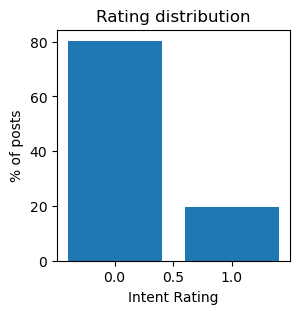

Class imbalance: [0.8 0.2]


In [166]:
values, counts = np.unique(df['Intent'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Intent Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()


print(f"Class imbalance: {np.round(normalized_counts, 2)}")

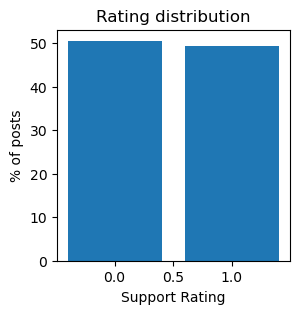

Class imbalance: [0.51 0.49]


In [167]:
values, counts = np.unique(df['Support'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Support Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()
print(f"Class imbalance: {np.round(normalized_counts, 2)}")

### 2.1.1. Custom Tokenization function

In [168]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = [] #"you're", 'billion',"that's", "let's", 'gamestop', 'gme' ]

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

In [169]:
# Defining my tokenisation function
def my_tokenizer(document, lemmatization=True, stemming=False):
    '''
    Function for use in Vectorizer that tokenizes the document.
    
    Parameters:
    - document: The text to be tokenized.
    - lemmatization: If True, perform lemmatization.
    - stemming: If True, perform stemming.
    
    Returns:
    - A list of tokens.
    '''
    
    # Replace newline characters with an empty string
    document = document.replace("\n", "")

    # Replace non-alphabetic characters with a space
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)

    # Strip leading and trailing spaces
    document = document.strip()

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word.lower() not in stop_words]

    # Perform stemming if set to True
    if stemming:
        stemmer = PorterStemmer()
        tokenized_document = [stemmer.stem(word) for word in tokenized_document]

    # Perform lemmatization if set to True
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokenized_document = [lemmatizer.lemmatize(word) for word in tokenized_document]

    return tokenized_document


#EXTRA
#to modify the default parameters of my_tokenizer_pattern we can use a lambda function in-place:
#count_vectorizer = CountVectorizer(tokenizer=lambda document: my_tokenizer(document, lemmatization=True, stemming=False))

#what if we only wanted to extract letters, without numeric characters
#consider changing the pattern to pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"

In [170]:
# store simplified data in X and y
X = df['Text']
y = df['Intent']

# splitting our data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

# size of training data
X_train.shape

(4000,)

## 2.2. Vectorisation 

In [171]:
# Initialise a CountVectorizer object
count_vectorizer = CountVectorizer(tokenizer=my_tokenizer,
                                   stop_words=stop_words, # using stop words list that has been customised
                                   min_df=0.005, 
                                   ngram_range=(1,4), 
                                   max_features=1000)

# Preprocess the stop words with the custom tokenizer logic (if applicable)
processed_stop_words = set(my_tokenizer(' '.join(stop_words)))

# Fit the CountVectorizer object on X_train
count_vectorizer.fit(X_train)

# Fit the CountVectorizer object on X_train
X_matrix_train = count_vectorizer.transform(X_train)

print(X_matrix_train.shape);

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(4000, 626)


In [172]:
# sum all the rows for each feature
word_counts = pd.DataFrame(
        {"counts": np.array(X_matrix_train.sum(axis=0)).flatten()},
        index=count_vectorizer.get_feature_names_out()).sort_values("counts", ascending=False)

print('The most common words and their counts are:')
word_counts[:20]

The most common words and their counts are:


,counts
gme,4142
buy,794
stock,740
share,719
like,554
amc,531
short,518
get,414
gamestop,412
people,400


In [173]:
#toarray() method converts sparse matrix to a DataFrame
pd.DataFrame(X_matrix_train.toarray(),columns=count_vectorizer.get_feature_names_out()).head()

,able,account,action,actual,actually,advice,afford,ago,agree,allow,...,www reddit com,www reddit com r,x,x b,yeah,year,yes,yesterday,yet,yolo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


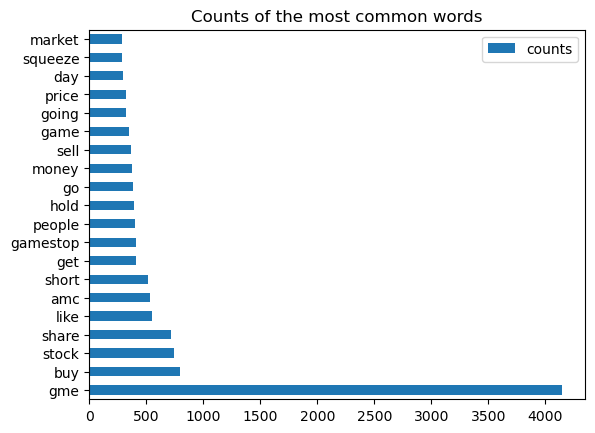

In [174]:
word_counts[:20].plot(kind='barh',title='Counts of the most common words')
plt.show()

Observations:  

* The list of words assocaited with neagtive reviews is quite revealing. 
* Customers clearly dislike unclean small rooms, tired decor, rude staff, poor breakfast selection, expensive hotels where quality does not match the price, broken amenities, noise and poor service.

## 2.3. Simple Logistic Regression

Now that we are happy with the number of features, let's fit a classification model and preprocess the test set

In [175]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(1001, 626)

In [176]:
logistic_model=LogisticRegression()
logistic_model.fit(X_matrix_train,y_train)
print(f"Train set accuracy {logistic_model.score(X_matrix_train,y_train):.2f}")
print(f"Test set accuracy {logistic_model.score(X_matrix_test,y_test):.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Train set accuracy 0.88
Test set accuracy 0.83
Test Accuracy: 0.8581
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       804
           1       0.66      0.57      0.61       197

    accuracy                           0.86      1001
   macro avg       0.78      0.75      0.76      1001
weighted avg       0.85      0.86      0.85      1001

Confusion Matrix:
[[746  58]
 [ 84 113]]


* Note, train scores can also be used as one of the metrics to select the optimal min_df & max_df parameters
* Now we can use the model object to access and specifically its **coef_** amd **feature_names_in_** attributes to plot which tokens have the greatest predictive power of negative and postiive reviews
    * Note this approach is only going to work if the model was fitted on a dataframe with the correct feature names, if an array was used, feature names can be extracted from the vectorizer used previously

*---------------------------------------------------------------------*
### Model Analysis

/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_25697/1687988034.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_25697/1687988034.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)


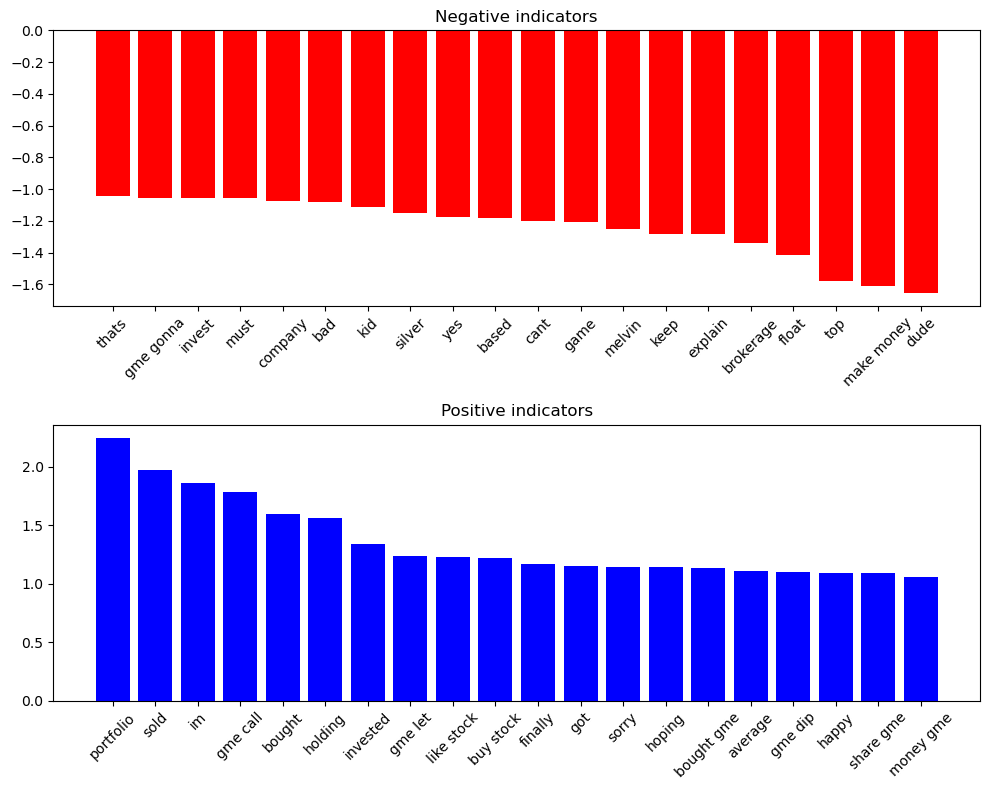

In [177]:
def plot_coefs(model):
    # Create a DataFrame to store the coefficients and corresponding tokens
    coef_df = pd.DataFrame({"coefficient": model.coef_[0], "token": count_vectorizer.get_feature_names_out()})
    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plot tokens indicating negative sentiment with smallest coefficients
    axs[0].bar(coef_df.tail(20)["token"], coef_df.tail(20)["coefficient"], color="red")
    axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
    axs[0].set_title("Negative indicators")

    # Plot tokens indicating positive sentiment with largest coefficients
    axs[1].bar(coef_df.head(20)["token"], coef_df.head(20)["coefficient"], color="blue")
    axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)
    axs[1].set_title("Positive indicators")

    fig.tight_layout()
    plt.show()

plot_coefs(logistic_model)

Observation:  

The model accuracy on test set is close to the accuracy on the train and valildation sets. This is a good sign, as it inidcates there is no problem with overfitting the model.  We have sufficient number of observations to train the model so that when it is faced with unseen test data it still performs well.   

## 2.X. Gridsearch for logreg

In [178]:
# Pipeline composition, includes preprocessing and the classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Vectorization
    ('svd', TruncatedSVD(n_components=100)),  # Dimensionality reduction for sparse data, using SVD instead of PCA for sparse data
    ('logr', LogisticRegression(solver='liblinear'))  # Classifier with  liblinear solver - good for small datasets
])

# Define the hyperparameters space to search
param_grid = {
    'tfidf__max_df': [0.8, 0.85, 0.9], # ignore terms that appear in more than XX% of the documents. 
    'tfidf__ngram_range': [(1, 2), (1, 3)], # both unigrams and bigrams will be used as features
    'tfidf__stop_words': ('stop_words', None),
    'svd__n_components': [150, 175, 200], # reduce the feature space to the top 100 components
    'logr__C': [10, 100, 200]
}

# Set up GridSearchCV to search for the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# X_train on the raw text data
grid_search.fit(X_train, y_train)

# After fitting, get the best estimator
best_model = grid_search.best_estimator_

# Predict the test set using the best model
test_predictions = best_model.predict(X_test)

In [179]:
# Calculate the accuracy
test_accuracy = accuracy_score(y_test, test_predictions)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Best hyperparameters: {'logr__C': 100, 'svd__n_components': 150, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 2)}
Test Accuracy: 0.8631
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       804
           1       0.66      0.62      0.64       197

    accuracy                           0.86      1001
   macro avg       0.79      0.77      0.78      1001
weighted avg       0.86      0.86      0.86      1001

Confusion Matrix:
[[741  63]
 [ 74 123]]


In [180]:
# Save the best model using joblib
#joblib.dump(best_model, "../model/labeled_yes_best_linear_grid_search_model.pkl")
# print("Best model saved to '../model/labeled_yes_best_linear_grid_search_model.pkl'")

Best model saved to '../model/labeled_yes_best_linear_grid_search_model.pkl'


The original version with PCA is below:

In [181]:
# Set up a pipeline
# PCA does not support sparse input, converting sparce matrix into a dense matrix
#X_matrix_train_dense = X_matrix_train.toarray()
#X_matrix_test_dense = X_matrix_test.toarray()

In [182]:
# Create a pipeline with PCA and a decision tree classifier
if False: 

    pipeline = Pipeline([
        ('pca', PCA(n_components=20)),
        ('logr', LogisticRegression(solver='liblinear'))  # 'solver' to ensure compatibility with smaller datasets
    ])

    # Define the hyperparameters
    param_grid = {
        'logr__C': [0.1, 0.5, 1, 10, 100, 1000]  
    }

    ### 2.5.2. Hyperparameter optimization
    
    # Set up GridSearchCV 
    grid_search = GridSearchCV(pipeline, param_grid, cv=5)
    grid_search.fit(X_matrix_train_dense, y_train)

    # Print the best hyperparameters
    print("Best hyperparameters:", grid_search.best_params_)

## 2.X. Model Performance Evaluation

## 2.4. Text analysis conclusions

## 2.5. Decision Tree Classifier

### 2.5.1. Set up a pipeline

In [183]:
# PCA does not support sparse input, converting sparce matrix into a dense matrix
X_matrix_train_dense = X_matrix_train.toarray()
X_matrix_test_dense = X_matrix_test.toarray()

In [184]:
# Create a pipeline with PCA and a decision tree classifier
pipeline = Pipeline([
    ('pca', PCA(n_components=20)),
    ('clf', DecisionTreeClassifier())
])

In [185]:
# Define the hyperparameters
param_grid = {
    'clf__max_depth': [1,2, 3, 5, 7, 10, 15,20], 
    'clf__min_samples_split': [2,3,4,5,6,7,8], 
    'clf__min_samples_leaf': [2,4,5,6,7,8]  
}

### 2.5.2. Hyperparameter optimization

* I use GridSearchCV to search over a specified parameter grid. 
* I tried to set up Gridsearch to do the pre-processing (Vectorisation) but I could not figure out how to do it. 
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.  

In [186]:
# Set up GridSearchCV 
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

In [187]:
grid_search.fit(X_matrix_train_dense, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=20)),
                                       ('clf', DecisionTreeClassifier())]),
             param_grid={'clf__max_depth': [1, 2, 3, 5, 7, 10, 15, 20],
                         'clf__min_samples_leaf': [2, 4, 5, 6, 7, 8],
                         'clf__min_samples_split': [2, 3, 4, 5, 6, 7, 8]})

In [188]:
# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'clf__max_depth': 1, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}


### 2.5.3. Parameters to optimize.

In [189]:
best_model = grid_search.best_estimator_

# Using the dense version of X_test, which is X_matrix_test_dense
test_preds = best_model.predict(X_matrix_test_dense)

# Accuracy using the true labels y_test and the predicted labels test_preds
val_acc = accuracy_score(y_test, test_preds)
print(f"Validation Accuracy with Best Parameters: {val_acc:.4f}")

Validation Accuracy with Best Parameters: 0.8032


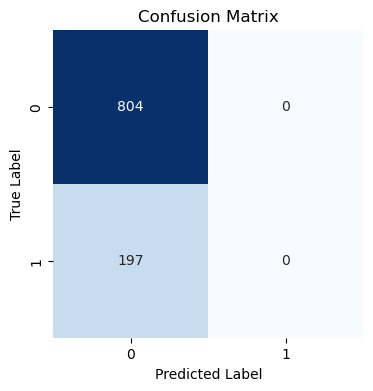

In [190]:
matrix = confusion_matrix(y_test, test_preds)

# Displaying the confusion matrix 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [191]:
# Printing the classification report
report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       804
           1       0.00      0.00      0.00       197

    accuracy                           0.80      1001
   macro avg       0.40      0.50      0.45      1001
weighted avg       0.65      0.80      0.72      1001



/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Observation:  

* The DT classifier combined with the gridsearch for best hyperparameters combination have not resulted in  a better model than the logistical regression constratucted earlier.  The accuracy score of 74% is lower than 78% for the logreg model.  BUt 74% is still better than the 57% for the majority class os 1s. 
* The DT model has a slightly better performance in classifying positive reviews (1s) with a precision of 0.76 and recall of 0.80, compared to classifying negative reviews (0s) which has a precision of 0.72 and recall of 0.67. 
* Overall, with an accuracy is 0.74. The model classifies well between positive and negative reviews, although there's a margin for improvement.